# Proyecto Statistical Learning I

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics

#habilitamos compatibilidad para TensorFlow v1
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
titanic_dataset = pd.read_csv('data_titanic_proyecto.csv')

train_data, test_data = train_test_split(titanic_dataset, test_size=0.2)
train_data, validation_data = train_test_split(train_data, test_size=0.2)

train_data

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
634,635,"Skoog, Miss. Mabel",9.0,3,2,347088,27.9000,NaN,S,Lower,F,N
747,748,"Sinkkonen, Miss. Anna",30.0,0,0,250648,13.0000,NaN,S,Middle,F,Y
48,49,"Samaan, Mr. Youssef",NaN,2,0,2662,21.6792,NaN,C,Lower,M,N
838,839,"Chip, Mr. Chang",32.0,0,0,1601,56.4958,NaN,S,Lower,M,Y
477,478,"Braund, Mr. Lewis Richard",29.0,1,0,3460,7.0458,NaN,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...,...,...,...
219,220,"Harris, Mr. Walter",30.0,0,0,W/C 14208,10.5000,NaN,S,Middle,M,N
450,451,"West, Mr. Edwy Arthur",36.0,1,2,C.A. 34651,27.7500,NaN,S,Middle,M,N
137,138,"Futrelle, Mr. Jacques Heath",37.0,1,0,113803,53.1000,C123,S,Upper,M,N
671,672,"Davidson, Mr. Thornton",31.0,1,0,F.C. 12750,52.0000,B71,S,Upper,M,N


### Análisis exploratorio de datos

In [4]:
train_data.isna().sum()

PassengerId             0
Name                    0
Age                   110
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 444
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

In [5]:
for column in train_data.drop(['Cabin'],axis=1):
    print(column+" : "+str(train_data[column].dropna().unique().shape[0]))

PassengerId : 569
Name : 569
Age : 83
SibSp : 7
Parch : 7
Ticket : 470
Fare : 204
Embarked : 3
passenger_class : 3
passenger_sex : 2
passenger_survived : 2


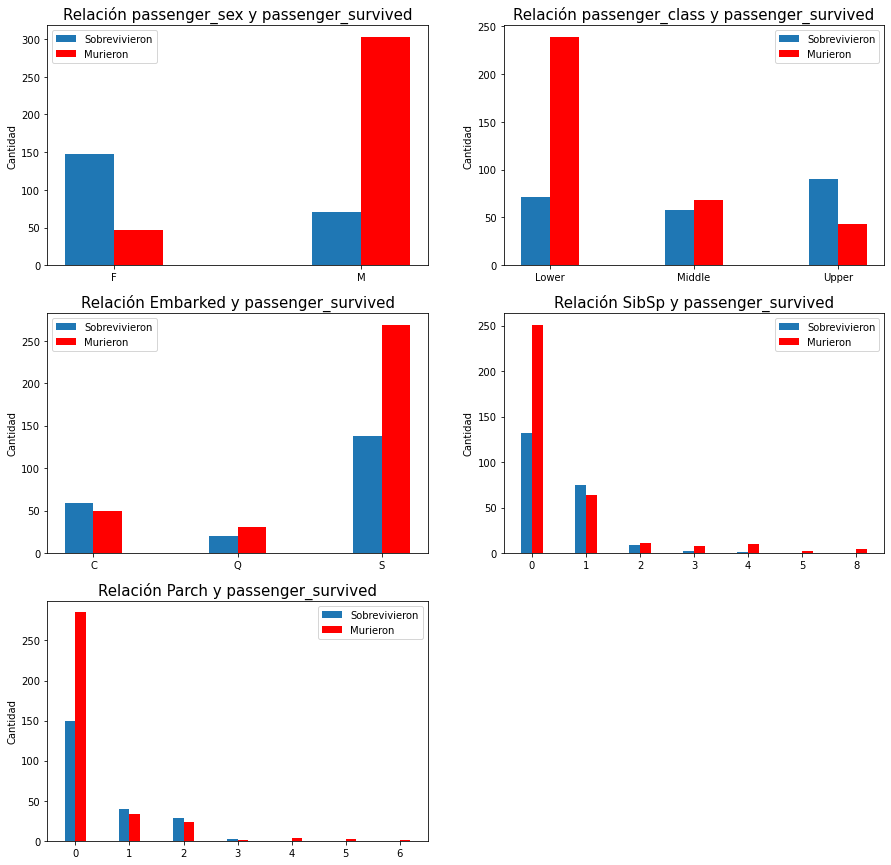

In [6]:
f,axes = plt.subplots(3,2,sharex=False, figsize=(15,15))
i_vars = ["passenger_sex","passenger_class","Embarked","SibSp","Parch"]

for i in range(len(i_vars)):
    ivar = i_vars[i]
    labels = sorted(train_data[ivar].dropna().unique())
    survivors = []
    deaths = []
    for label in labels:
        survivors.append(train_data[(train_data[ivar] == label) & (train_data["passenger_survived"] == "Y")][ivar].count())
        deaths.append(train_data[(train_data[ivar] == label) & (train_data["passenger_survived"] == "N")][ivar].count())
        
    width = 0.20
    x_plt = np.arange(len(labels))
    
    ax = axes[i//2,i%2]
    rects1 = ax.bar(x_plt, survivors, width, label='Sobrevivieron')
    rects2 = ax.bar(x_plt + width, deaths, width, label='Murieron',color="red")

    ax.set_ylabel('Cantidad')
    ax.set_title('Relación '+ivar+' y passenger_survived', fontsize=15)
    ax.set_xticks(x_plt+width/2)
    ax.set_xticklabels(labels)
    ax.legend()
    
f.delaxes(axes[2,1])
plt.show()

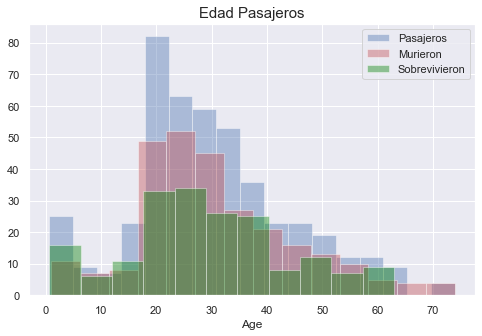

In [7]:
sns.set();
plt.figure(figsize=(8,5))
sns.distplot(train_data["Age"].dropna(), kde=False, label="Pasajeros")
sns.distplot(train_data[(train_data["passenger_survived"] == "N")]["Age"].dropna(),color="r", kde =False, label="Murieron")
sns.distplot(train_data[(train_data["passenger_survived"] == "Y")]["Age"].dropna(), color="green", kde =False, label="Sobrevivieron")
plt.title("Edad Pasajeros",fontsize=15)
plt.legend()
plt.show()

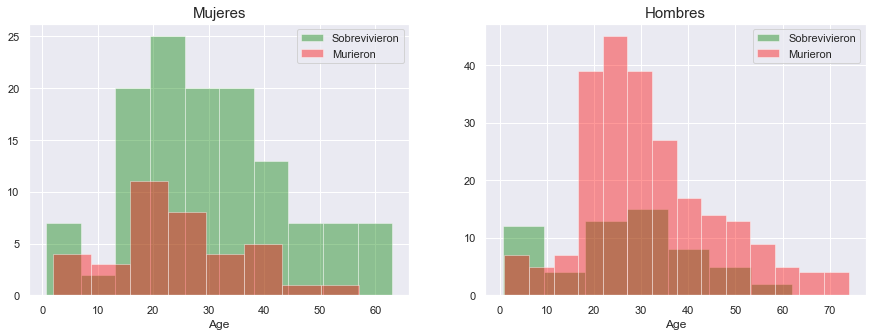

In [8]:
sns.set();

f,axes = plt.subplots(1,2,sharex=False, figsize=(15,5))

sns.distplot(train_data[(train_data["passenger_sex"] == "F") & (train_data["passenger_survived"] == "Y")]["Age"].dropna(), color="green", kde=False, ax=axes[0],label="Sobrevivieron")
sns.distplot(train_data[(train_data["passenger_sex"] == "F") & (train_data["passenger_survived"] == "N")]["Age"].dropna(), color="red", kde=False, ax=axes[0],label="Murieron")
sns.distplot(train_data[(train_data["passenger_sex"] == "M") & (train_data["passenger_survived"] == "Y")]["Age"].dropna(), color="green", kde=False,ax=axes[1], label="Sobrevivieron")
sns.distplot(train_data[(train_data["passenger_sex"] == "M") & (train_data["passenger_survived"] == "N")]["Age"].dropna(), color="red", kde=False, ax=axes[1],label="Murieron")
axes[0].legend()
axes[0].set_title("Mujeres",fontsize=15)
axes[1].legend()
axes[1].set_title("Hombres",fontsize=15)
plt.show()

In [10]:
#corr = train_data.corrwith(train_data["passenger_survived"])

#plt.figure(figsize=(12,6))
#sns.heatmap(train_data.corr(), cmap="Blues", annot=True)

#corr.to_frame().T

### Naive Bayes

In [3]:

weather=['Sunny','Sunny','Overcast','Rainy','Rainy','Rainy','Overcast','Sunny','Sunny',
'Rainy','Sunny','Overcast','Overcast','Rainy']
temp=['Hot','Hot','Hot','Mild','Cool','Cool','Cool','Mild','Cool','Mild','Mild','Mild','Hot','Mild']

play=['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']


df = pd.DataFrame({
    'weather' : weather,
    'temp' : temp,
     'play' : play
})


#df = pd.DataFrame({
#    'X1': [3.393533211,3.110073483, 1.343808831, 3.582294042,2.280362439,7.423436942,5.745051997,9.172168622,7.792783481,7.939820817],
#    'X2': [2.331273381,1.781539638,3.368360954,4.67917911,2.866990263,4.696522875,3.533989803,2.511101045,3.424088941,0.791637231],
#    'Y': [0,0,0,0,0,1,1,1,1,1]
#})


#df = pd.DataFrame({
#    'X1': [3.393533211,3.110073483, 1.343808831, 3.582294042,2.280362439,7.423436942,5.745051997,9.172168622,7.792783481,7.939820817],
#    'X2': [2.331273381,1.781539638,3.368360954,4.67917911,2.866990263,4.696522875,3.533989803,2.511101045,3.424088941,0.791637231],
#    'Y': [0,0,0,0,0,1,1,1,1,1]
#})


    #return (1 / (sqrt(2 * pi) * stdev)) * exponent

df.to_dict('index')
df["Y"] = df["play"].map( {'No': 0, 'Yes': 1}).astype(int)
df["weather_encoded"] = df["weather"].map( {'Overcast': 0, 'Rainy': 1,'Sunny':2}).astype(int)
df["temp_encoded"] = df["temp"].map( {'Cool': 0, 'Hot': 1,'Mild':2}).astype(int)


x_test = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]])
y_test = [1,0,1]
x_test.reshape(-1,1)

#empieza aqui
means = df.groupby('Y').mean()
stds = df.groupby('Y').std()

class_prob = df.groupby('Y')['Y'].count() / df.shape[0]

predictions = np.zeros((len(df['Y'].unique()),x_test.shape[0]))
for c in df['Y'].unique():
    mean = means.iloc[c].to_numpy()
    std = stds.iloc[c].to_numpy() 
    vars_prob = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x_test-mean)**2 / (2 * std**2 )))
    probablilites = class_prob[c]*np.product(vars_prob,axis=1)
    predictions[c] = probablilites

y_pred = np.argmax(predictions.T,axis=1)

print(y_pred)
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    


#print(means)

[1 1 1 1 1 1 0 0 0]


In [4]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
weather_encoded=le.fit_transform(weather)
temp_encoded=le.fit_transform(temp)
label=le.fit_transform(play)
features=zip(weather_encoded,temp_encoded)

from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(list(features),label)

#Predict Output
predicted= model.predict(x_test) # 0:Overcast, 2:Mild
print("Predicted Value:", predicted)

Predicted Value: [1 1 1 1 1 1 0 0 0]


### SVM

In [5]:
from sklearn import svm

clf = svm.SVC(kernel='linear') 

clf.fit(df[["weather_encoded","temp_encoded"]],df["Y"])

y_pred = clf.predict(x_test)
y_pred

array([1, 1, 1, 1, 1, 1, 0, 0, 0])

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(df[["weather_encoded","temp_encoded"]],df["Y"])
y_pred = clf.predict(x_test)

y_pred

array([1, 1, 1, 0, 0, 1, 1, 0, 0])

In [9]:
from sklearn.tree import export_graphviz

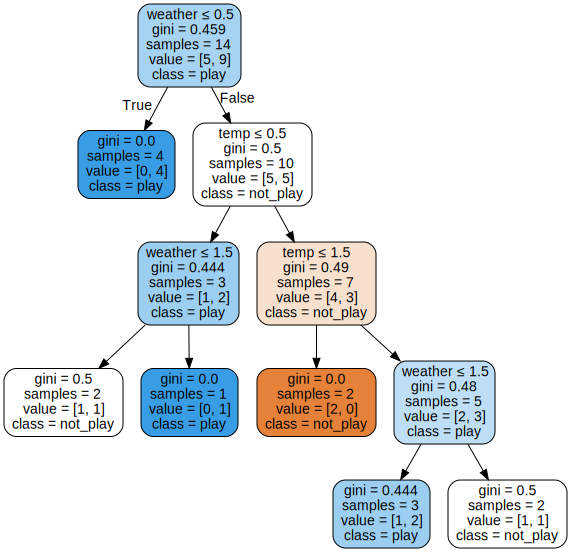

In [10]:
dot_data = export_graphviz(clf, out_file=None,
                                        feature_names=["weather","temp"],
                                        class_names=["not_play","play"],
                                        filled=True, rounded=True,
                                        special_characters=True)
graph = graphviz.Source(dot_data)
graph